In [1]:
%reset-f
%load_ext autoreload
%autoreload 2

This notebook demonstrates the usage of the resilience/socio-economic capacity model with multi hazard and multi return period data. First look at the simple case in [socio_economic_capacity_demo](socio_economic_capacity_demo.ipynb)

# Loading functions

We first import function librairies. The first ones are standard python librairies.

In [2]:
#The main library we use. Manipulates Excel-like tables (called dataframes) with named rows and columns
import pandas as pd 

In [3]:
#ploting capacities
import matplotlib.pyplot as plt 
#make plots appear in this notebook
%matplotlib inline  

#Default options for plots: this controls the font used in figures
font = {'family' : 'sans serif',
    'size'   : 18}
plt.rc('font', **font)


# Loading and exploring the data

Here we read the data set we need into a pandas table (called DataFrame).
This specific dataset was put together from a variety of different sources using another python notebook: [data_gathering_demo.ipynb](data_gathering_demo.ipynb). In the future we could build directly an excel file with all the data the model needs.

## General data

In [4]:
#Load the excel data file into a dataframe (table)
df=pd.read_excel("inputs/all_data_compiled.xlsx", 
                 index_col=0, #tells Pandas to use the first column (Provinces) as the index of the table
                 skiprows=[0, 2] #The first (0) row is a description of the variables and the 3rd (2) row is empty. We skip them
                ) 
df.index.name="province" #rename the index to "province" for clarity
#Displays the first rows of that dataframe
df.head()

,gdp_pc_pp,pop,pov_head,shew,gdp_pc_pp_nat,rel_gdp_pp,share1,national_pop,axfin_p,axfin_r,...,v_r,protection,avg_prod_k,T_rebuild_K,pi,nat_buyout,sigma_r,sigma_p,income_elast,rho
province,,,,,,,,,,,,,,,,,,,,,
Abra,31.622466,240135.244121,0.373595,0.953416,42.034627,0.752296,0.509132,83650215.459496,0.693233,0.693233,...,0.100000,10.57,0.23,3,0.2,0.3,0,0,1.5,0.05
Agusan Del Norte,43.726667,661728.454375,0.346715,0.821277,42.034627,1.040253,0.368196,83650215.459496,0.496880,0.496880,...,0.100000,9.41,0.23,3,0.2,0.3,0,0,1.5,0.05
Agusan Del Sur,30.897436,677779.682154,0.480785,0.821277,42.034627,0.735047,0.521079,83650215.459496,0.475969,0.475969,...,0.100000,8.61,0.23,3,0.2,0.3,0,0,1.5,0.05
Aklan,30.515652,554414.442422,0.249662,0.823003,42.034627,0.725965,0.527598,83650215.459496,0.660083,0.660083,...,0.135089,2.00,0.23,3,0.2,0.3,0,0,1.5,0.05
Albay,33.793313,1264097.894966,0.409587,0.800000,42.034627,0.803940,0.476426,83650215.459496,0.551314,0.551314,...,0.100000,2.00,0.23,3,0.2,0.3,0,0,1.5,0.05


The columns names correspond to variables in the resilience assessment model, so they are not all self-explanatory. For a description of the variables, see above, or clic on [inputs/inputs_info.csv](inputs/inputs_info.csv)

## Multi hazard data

The model can also handle data for different hazards. Here we have estimates of exposure of poor and nonpoor people to hazard and river floods in some provinces of the Philippines. 

In [5]:
multihazard_info = pd.read_csv("inputs/multi_hazard_data.csv", index_col=["province","hazard"])
multihazard_info.head()

fap       far
province         hazard                    
Abra             coast   0.000000  0.000000
                 river   0.188715  0.149419
Agusan Del Norte coast   0.114415  0.091571
                 river   0.365700  0.292684
Agusan Del Sur   coast   0.011681  0.008747

In the future, we can add hazard-dependent data on protection, asset vulnerability, and early warnings to this table. We can also add data on other types of hazard.

For a given hazad, exposure depends on the return period. More poeple tend to be exposed to less frequent (more extreme) events. This information is given to the model in a third table.

## Multi return period data

In [6]:
fa_ratios  = pd.read_csv("inputs/fa_ratios.csv", index_col=["province","hazard"]).sortlevel()
fa_ratios.columns=fa_ratios.columns.map(float)
fa_ratios.head()
fa_ratios = fa_ratios
fa_ratios.columns.name="rp"
fa_ratios.head()

rp                       10        100
province         hazard               
Abra             coast     1  1.000000
                 river     1  1.814138
Agusan Del Norte coast     1  1.000000
                 river     1  1.081761
Agusan Del Sur   coast     1  1.000000

# Computing socio-economic capacity

Now let us use the resilience model with multi hazard and multi return period data. Let us first read the function definitions, from [res_ind_lib.py](res_ind_lib.py)

#### Loading functions

In [7]:
from res_ind_lib import *     #MAIN library: the functions used to compute risk, resilience, etc

#### Defining reference variabes

Before running the model, for technical reasons, we need to define "reference" values for some variables. The following function does it.

In [8]:
df = def_ref_values(df).dropna()
df[["protection", "protectionref"]].head()

,protection,protectionref
province,,
Abra,10.57,10.57
Agusan Del Norte,9.41,9.41
Agusan Del Sur,8.61,8.61
Aklan,2.00,2.00
Albay,2.00,2.00


#### Comparing risk to assets, capacity, and risk to welfare

The function compute_resiliences computes risk and capacity from all the data.

In [9]:
for c in multihazard_info.unstack("hazard").head():
    print(c)

('fap', 'coast')
('fap', 'river')
('far', 'coast')
('far', 'river')


In [10]:
hop=multihazard_info.unstack("hazard")
hop["fap","coast"]+=10
hop.stack("hazard").head()

fap       far
province         hazard                     
Abra             coast   10.000000  0.000000
                 river    0.188715  0.149419
Agusan Del Norte coast   10.114415  0.091571
                 river    0.365700  0.292684
Agusan Del Sur   coast   10.011681  0.008747

In [11]:
multihazard_info.head()

fap       far
province         hazard                    
Abra             coast   0.000000  0.000000
                 river   0.188715  0.149419
Agusan Del Norte coast   0.114415  0.091571
                 river   0.365700  0.292684
Agusan Del Sur   coast   0.011681  0.008747

In [12]:
df_with_results=compute_resiliences(df, fa_ratios=fa_ratios,  multihazard_data=multihazard_info)

Outputs of that function are identical to the ones we get without multihazard or multi return period data. Let us see how estimates of risk to assets, socio-economic capacity and expected welfare losses change with multihazard and return periods data.

In [13]:
out    = compute_resiliences(df)
out_m  = compute_resiliences(df, multihazard_data=multihazard_info)
out_mr = compute_resiliences(df, fa_ratios=fa_ratios,  multihazard_data=multihazard_info)

(0.01593212108168948, 0.0031591999581473424)

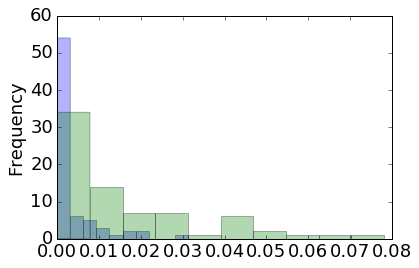

In [14]:
#addiging multihazard data slightly increases the estimates of risk. 
#This is because the data in df is about river floads only, while multihazard_info has coastatal floods in addition.
out.risk.plot.hist(alpha=0.3,color="blue")
out_m.risk.plot.hist(alpha=0.3, color="green")

out_m.risk.mean(), out.risk.mean()

(0.01593212108168948, 0.016844136395086102)

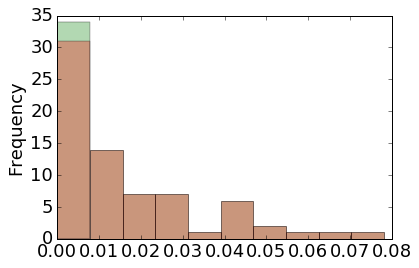

In [15]:
#it turns out that addiging multi return period data does not change risk to welfare as much
out_m.risk.plot.hist(alpha=0.3, color="green")
out_mr.risk.plot.hist(alpha=0.3, color="red")

out_m.risk.mean(), out_mr.risk.mean()

# Export main results

Now we add a description to each column (from [inputs/inputs_info.csv](inputs/inputs_info.csv)) and save the resulting table

In [16]:
#read descritpion of each variable
description = pd.read_csv("inputs/inputs_info.csv", index_col="key")["descriptor"]
description.head()

#copy of the results
data = df_with_results.copy()

#adds description line
data.ix["description"]= description

#makes that line part of the index
data=data.T.reset_index().set_index(["description","index"]).T
data.columns.names = ['description', 'variable']

#exports the result to a CSV file
data.to_csv("results/all_data_and_results.csv")

#displays the first few provinces, transposed for ease of reading.
data.head().T

,province,Abra,Agusan Del Norte,Agusan Del Sur,Aklan,Albay
description,variable,,,,,
Average income in the province,gdp_pc_pp,31.6225,43.7267,30.8974,30.5157,33.7933
Population,pop,240135,661728,677780,554414,1.2641e+06
Poverty incidence,pov_head,0.373595,0.346715,0.480785,0.249662,0.409587
Access to early warning,shew,0.953416,0.821277,0.821277,0.823003,0.8
National GDP per capita,gdp_pc_pp_nat,42.0346,42.0346,42.0346,42.0346,42.0346
Average income of the province (relative to national),rel_gdp_pp,0.752296,1.04025,0.735047,0.725965,0.80394
Relative income of poor families,share1,0.509132,0.368196,0.521079,0.527598,0.476426
National population,national_pop,8.36502e+07,8.36502e+07,8.36502e+07,8.36502e+07,8.36502e+07
Access to finance for poor people,axfin_p,0.693233,0.49688,0.475969,0.660083,0.551314


# Categorizing provinces

Here we categorize provinces in 3 tiers (Low, mid, high) according to their ranking on socio-econic capacity and on overall risk to welfare. We use the functions `make_tiers` and `categories_to_formated_excel_file` from [res_ind_lib.py](res_ind_lib.py)

In [17]:
categories = pd.DataFrame([make_tiers(df_with_results.risk_to_assets),
                           make_tiers(df_with_results.resilience),
                           make_tiers(df_with_results.risk), 
                           ]).T.dropna()
categories_to_formated_excel_file(categories,"results/categories.xlsx")
categories.rename(columns=description).head()

,Risk to assets,Socio-economic capacity,Expected welfare losses
Abra,Mid,Mid,Mid
Agusan Del Norte,High,Mid,High
Agusan Del Sur,Mid,Low,High
Aklan,High,Mid,High
Albay,Low,Low,Low
